In [17]:
import math

from keras.datasets import mnist

import numpy as np

import matplotlib.pyplot as plt

import scipy.stats as st

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn import metrics

In [14]:
SEED = 472889135
RNG = np.random.default_rng(SEED)

plt.style.use('e3mlm.mplstyle')

n_train = 2000
n_test = 200
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = np.array([x.flatten() for x in X_train])[:n_train]
y_train = y_train[:n_train]
X_test = np.array([x.flatten() for x in X_test])[:n_test]
y_test = y_test[:n_test]

## Test of proportions

In [15]:
rf = RandomForestClassifier()
svc = SVC()

rf.fit(X_train, y_train)
acc_rf = metrics.accuracy_score(y_test, rf.predict(X_test))

svc.fit(X_train, y_train)
acc_svc = metrics.accuracy_score(y_test, svc.predict(X_test))

(acc_rf, acc_svc)

(0.955, 0.95)

In [16]:
acc_avg = (acc_rf + acc_svc) / 2

z = (acc_rf - acc_svc) / math.sqrt(acc_avg * (1 - acc_avg) * (2/n_test))

z

0.23506648179478695

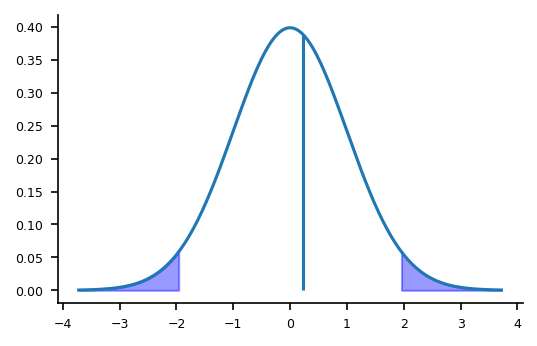

In [47]:
Z = st.norm()
x = np.linspace(Z.ppf(0.0001), Z.ppf(0.9999), 200)
y = Z.pdf(x)
plt.plot(x, y)

alpha = 0.05
z_alpha = Z.ppf(alpha/2)

x = np.linspace(Z.ppf(0.0001), z_alpha, 100)
plt.fill_between(x, Z.pdf(x), color=(0, 0, 1, 0.4))

x = np.linspace(-z_alpha, Z.ppf(0.9999), 100)
plt.fill_between(x, Z.pdf(x), color=(0, 0,1, 0.4))

plt.vlines([z], 0, [Z.pdf(z)])

plt.show()

In [51]:
if 2 * Z.pdf(-abs(z)) <= alpha:
    print('H0 refused: the two classifiers differ')
else:
    print('H0 accepted: the two classifier are equivalent')

H0 accepted: the two classifier are equivalent


In [83]:
def test_of_proportions(acc_1, acc_2, n_1, n_2, alpha=0.05,
                        plot=False, verbose=False):
    """Returns True in case of statistical difference between the two
    estimators, False if they are equivalent."""

    acc_12 = (acc_1 + acc_2) / 2
    z = (acc_1 - acc_2) / math.sqrt(acc_12 * (1 - acc_12) * (1/n_1 + 1/n_2))

    Z = st.norm()

    if plot:
        x = np.linspace(Z.ppf(0.0001), Z.ppf(0.9999), 200)
        y = Z.pdf(x)
        plt.plot(x, y)

        z_alpha = Z.ppf(alpha/2)

        x = np.linspace(Z.ppf(0.0001), z_alpha, 100)
        plt.fill_between(x, Z.pdf(x), color=(0, 0, 1, 0.4))

        x = np.linspace(-z_alpha, Z.ppf(0.9999), 100)
        plt.fill_between(x, Z.pdf(x), color=(0, 0,1, 0.4))

        plt.vlines([z], 0, [Z.pdf(z)])

        plt.show()

    p_value = 2 * Z.cdf(-abs(z))
        
    if verbose:
        print(f'Z statistic value is {z:.4f}')
        print(f'p-value is {p_value:.4f}, alpha is {alpha:.4f}')

    if p_value <= alpha:
        if verbose:
            print('H0 refused: the two classifiers differ')
        return True
    else:
        if verbose:
            print('H0 accepted: the two classifier are equivalent')
        return False

In [84]:
test_of_proportions(acc_rf, acc_svc, n_test, n_test)

False

In [85]:
test_of_proportions(acc_rf, acc_svc, n_test, n_test, verbose=True)

Z statistic value is 0.2351
p-value is 0.8142, alpha is 0.0500
H0 accepted: the two classifier are equivalent


False

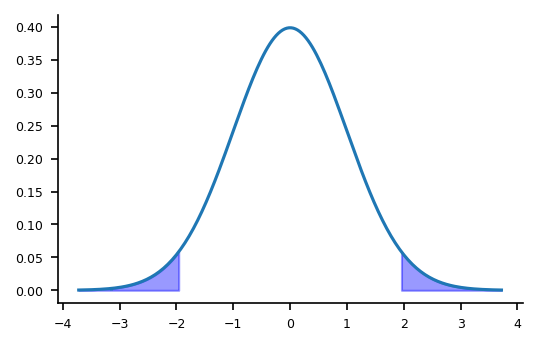

Z statistic value is -3.1498
p-value is 0.0016, alpha is 0.0500
H0 refused: the two classifiers differ


True

In [86]:
rf_3= RandomForestClassifier(n_estimators=3)
rf_9= RandomForestClassifier(n_estimators=9)

rf_3.fit(X_train, y_train)
acc_rf_3 = metrics.accuracy_score(y_test, rf_3.predict(X_test))

rf_9.fit(X_train, y_train)
acc_rf_9 = metrics.accuracy_score(y_test, rf_9.predict(X_test))

test_of_proportions(acc_rf_3, acc_rf_9, n_test, n_test,
                    plot=True, verbose=True)

In [87]:
acc_rf_3, acc_rf_9

(0.69, 0.825)

In [88]:
from statsmodels.stats.proportion import proportions_ztest
count = np.array([acc_rf_3, acc_rf_9])
nobs = np.array([n_test, n_test])
stat, pval = proportions_ztest(count, nobs)
print('{0:0.3f}'.format(pval))
print(stat)


0.912
-0.10988830098946793


## Chi-squared test

In [106]:
from sklearn import datasets

iris = datasets.load_iris()

In [108]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [118]:
from sklearn.model_selection import train_test_split

iris_X = iris['data'][iris['target']!=0]
iris_y = iris['target'][iris['target']!=0]

iris_X_train, iris_X_test, iris_y_train, iris_y_test = \
        train_test_split(iris_X, iris_y, stratify=iris_y, train_size=0.7)

In [119]:
svc_lin = SVC(kernel='linear')
svc_lin.fit(iris_X_train, iris_y_train)

SVC(kernel='linear')

In [120]:
svc_rbf = SVC(kernel='rbf')
svc_rbf.fit(iris_X_train, iris_y_train)

SVC()

In [121]:
import pandas as pd

In [124]:
predictions = pd.DataFrame({'svc_lin': svc_lin.predict(iris_X_test),
              'svc_rbf': svc_rbf.predict(iris_X_test)})
predictions.head()

,svc_lin,svc_rbf
0,2,2
1,1,1
2,1,1
3,2,2
4,2,2


In [132]:
contingency = pd.crosstab(predictions.svc_lin == 1, predictions.svc_rbf == 1)
contingency

svc_rbf,False,True
svc_lin,,
False,14,0
True,1,15


In [139]:
b, c = contingency.loc[True, False], contingency.loc[False, True]

In [154]:
stat = (b - c)**2 / (b + c)
stat

1.0

In [155]:
chi = st.chi2(1)
alpha = 0.05
p_value = 1 - chi.cdf(stat)
p_value

0.31731050786291415

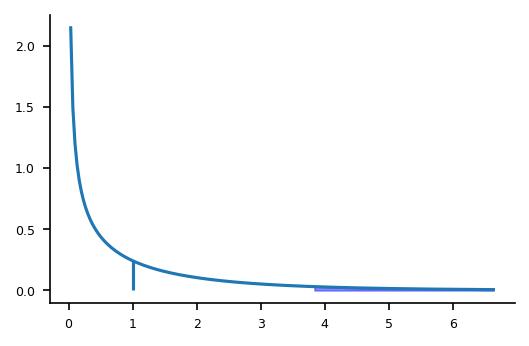

In [164]:
x = np.linspace(0, chi.ppf(0.99), 200)
plt.plot(x, chi.pdf(x))

x_limit = chi.ppf(1-alpha)

x = np.linspace(x_limit, chi.ppf(0.99), 100)
plt.fill_between(x, chi.pdf(x), color=(0, 0,1, 0.4))

plt.vlines([stat], 0, [chi.pdf(stat)])

plt.show()

In [165]:
def mc_nemar_test(pred_1, pred_2, class_1, alpha=0.05,
                  plot=False, verbose=False):
    contingency = pd.crosstab(pred_1 == class_1, pred_2 == class_1)
    b, c = contingency.loc[True, False], contingency.loc[False, True]
    stat = (b - c)**2 / (b + c)

    chi = st.chi2(1)
    p_value = 1 - chi.cdf(stat)

    if plot:
        x = np.linspace(0, chi.ppf(0.99), 200)
        plt.plot(x, chi.pdf(x))

        x_limit = chi.ppf(1-alpha)

        x = np.linspace(x_limit, chi.ppf(0.99), 100)
        plt.fill_between(x, chi.pdf(x), color=(0, 0,1, 0.4))

        plt.vlines([stat], 0, [chi.pdf(stat)])

        plt.show()

    if verbose:
        print(f'chi-squared statistic value is {stat:.4f}')
        print(f'p-value is {p_value:.4f}, alpha is {alpha:.4f}')

    if p_value <= alpha:
        if verbose:
            print('H0 refused: the two classifiers differ')
        return True
    else:
        if verbose:
            print('H0 accepted: the two classifier are equivalent')
        return False
    

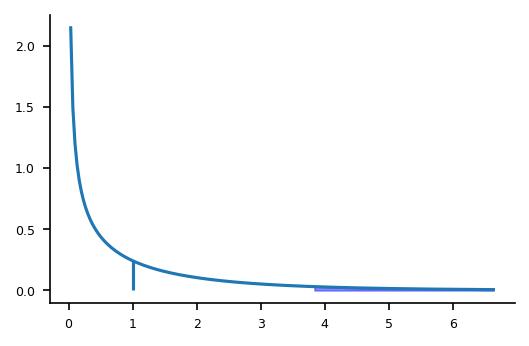

chi-squared statistic value is 1.0000
p-value is 0.3173, alpha is 0.0500
H0 accepted: the two classifier are equivalent


False

In [169]:
mc_nemar_test(predictions['svc_lin'], predictions['svc_rbf'], 1,
              verbose=True, plot=True)

In [170]:
from statsmodels.stats import contingency_tables as ct

res = ct.mcnemar(contingency, exact=False, correction=False)
print(res)

pvalue      0.31731050786291115
statistic   1.0


In [178]:
svc_rbf_simple = SVC(kernel='rbf', gamma=0.1)
svc_rbf_simple.fit(iris_X_train, iris_y_train)

svc_rbf_complex = SVC(kernel='rbf', gamma=100)
svc_rbf_complex.fit(iris_X_train, iris_y_train)

predictions = pd.DataFrame({'svc_rbf_simple': svc_rbf_simple.predict(iris_X_test),
              'svc_rbf_complex': svc_rbf_complex.predict(iris_X_test)})

contingency = pd.crosstab(predictions.svc_rbf_simple == 1,
                          predictions.svc_rbf_complex == 1)
contingency

svc_rbf_complex,False,True
svc_rbf_simple,,
False,15,0
True,9,6


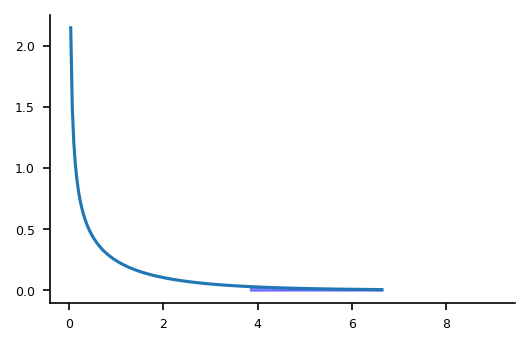

chi-squared statistic value is 9.0000
p-value is 0.0027, alpha is 0.0500
H0 refused: the two classifiers differ


True

In [179]:
mc_nemar_test(predictions['svc_rbf_simple'], predictions['svc_rbf_complex'], 1,
              verbose=True, plot=True)

In [189]:
res = ct.mcnemar(contingency, exact=False, correction=True)
print(res)

pvalue      0.007660761135179461
statistic   7.111111111111111


In [190]:
res = ct.mcnemar(contingency, exact=True, correction=False)
print(res)

pvalue      0.00390625
statistic   0.0
